# Load libraries

In [9]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPool2D, Input, Dropout, GlobalAveragePooling2D, Lambda, BatchNormalization
from tensorflow.keras import Model
print(tf.__version__)

2.3.1


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/uashogeschoolutrecht/tmoi-ml-19/blob/master/lesson%205/deeplearn3.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [10]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

No GPU was detected. CNNs can be very slow without a GPU.


In [11]:
# needs to be installed on colab
!pip install keras-tuner

In [12]:
import kerastuner as kt

# What are convolutions

We start by loading two sample images

In [13]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape
images.shape

(2, 427, 640, 3)

Now, we make two filters by hand. One with a horizontal line, one with a vertical line.

In [14]:
# Create 2 filters. The shape will be (kernel x kernel x channels x filters)
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line
filters[:, :, 0, 0] # have a look at the 0th filter in the 0th channel

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

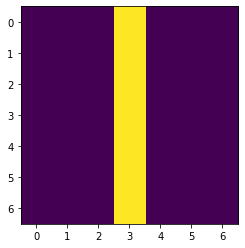

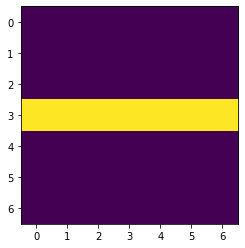

In [15]:
# and visualize them
plt.imshow(filters[:, :, 0, 0])
plt.show()
plt.imshow(filters[:, :, 0, 1])

Now we feed these filters to the images. The will be "slided" over the image, moving one pixel to the right. The filter calculates the values, and outputs the "resume" of this pattern as a single number. A convolution can be thought of as a "pattern detector", that detects patterns across bigger areas of pixels (to be exact, in the kernel size), in this example a 7x7 kernel.

In [16]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

Now, let's zoom in a little bit to see it more clearly. You can probably guess which filter does what.

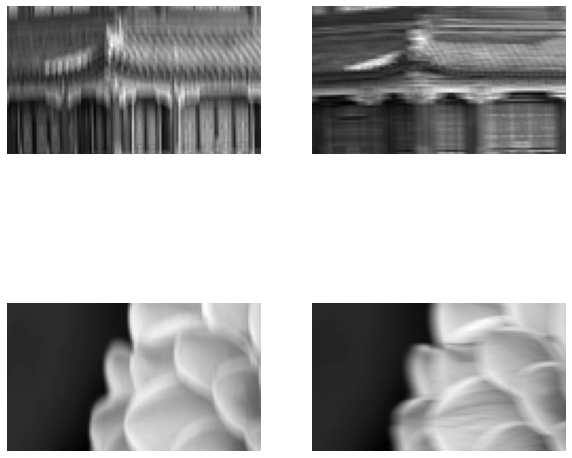

In [17]:
def crop(images):
    return images[150:220, 130:250]

plt.figure(figsize=(10, 10))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        #plt.imshow(image, cmap="gray", interpolation="nearest")
        plt.imshow(crop(outputs[image_index, :, :, feature_map_index]), cmap='gray')
        plt.axis("off")

We started with one image (or, better put: one images on three channels). The convulution looks for patterns and highlights them. The output are two images, one for every type of filter. This is increasing the amount of information we have to process. E.g., we had (batch x height x width x channels), and now we have (batch x height x width x filters), where filters can be 64 or 128 etc. So we would want to reduce the amount of information. That is where maxpooling comes in. The idea is kind of simple: just take a small window of pixels (e.g. a 2 by 2 window) and take the maximum value inside that window. Throw away everything else. Where we had height x width, we end up with an image only a quarter of the original size (because both height and width got sliced into halves).

In [18]:
max_pool = MaxPool2D(pool_size=2)
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)
cropped_images.shape, output.shape

((2, 70, 120, 3), TensorShape([2, 35, 60, 3]))

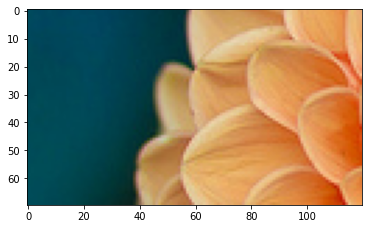

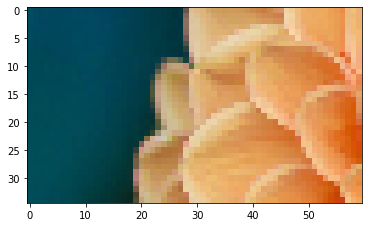

In [19]:
plt.imshow(cropped_images[1])
plt.show()
plt.imshow(output[1]) 

# Get the data
We already saw how we could push the accuracy up, just by adding a combination of `Conv2D` and `MaxPool2D` layers on top of our `Dense` layers. 

Now, let's try images that are much more challenging.

The data is downloaded from an url, and stored locally

In [20]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   cache_dir = '~/shared',
                                   cache_subdir = '',
                                   untar=True)

We have obtained 5 folders of photos, 230MB in size

In [21]:
# size in MB
!du -mh $data_dir

48M	/home/jupyter-raoul.grouls/shared/flower_photos/dandelion
35M	/home/jupyter-raoul.grouls/shared/flower_photos/daisy
40M	/home/jupyter-raoul.grouls/shared/flower_photos/roses
54M	/home/jupyter-raoul.grouls/shared/flower_photos/sunflowers
55M	/home/jupyter-raoul.grouls/shared/flower_photos/tulips
230M	/home/jupyter-raoul.grouls/shared/flower_photos


Containing more than 3000 files in total

In [22]:
!find $data_dir -type f | wc -l

3671


To load the data, we will have to create a generator.

In [24]:
def generate_generators(data_dir, img_size=(180,180), batch=32, split=0.2, augment=False):
    # we specify default arguments for rescaling and validation split
    datagen_kwargs = dict(rescale=1./255, validation_split=split)

    # and additional arguments for the flow from the directory
    # Interpolation: method used to resample the image if the target size is different from that of the loaded image
    dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                    interpolation="bilinear")
  
    #initialize ImageDataGenerator
    valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      **datagen_kwargs) # adding the default arguments
    
    #point to directory
    valid_generator = valid_datagen.flow_from_directory(
        data_dir, subset="validation", shuffle=False, **dataflow_kwargs)


    if augment:
    # to squeeze more out your data, modify images.
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20, # rotate some degrees
            horizontal_flip=True, # flip
            width_shift_range=0.2, # shift
            height_shift_range=0.2,
            zoom_range=0.2, # zoom
            **datagen_kwargs)
    else:
        train_datagen = valid_datagen
  
    # point to directory
    train_generator = train_datagen.flow_from_directory(
        data_dir, subset="training", shuffle=True, **dataflow_kwargs)
    return (train_generator, valid_generator)

In [25]:
BATCH_SIZE = 32
img_height = 180
img_width = 180
IMAGE_SIZE = (img_height, img_width)
train_generator, valid_generator = generate_generators(data_dir, 
                                                       img_size=IMAGE_SIZE, 
                                                       batch=BATCH_SIZE, 
                                                       split=0.2, 
                                                       augment=False)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [26]:
class_names = train_generator.class_indices
print(class_names)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [27]:
train_generator.num_classes

5

# Explore dataset
Let's visualize some images

(32, 180, 180, 3)
(32, 5)
[1. 0. 0. 0. 0.]


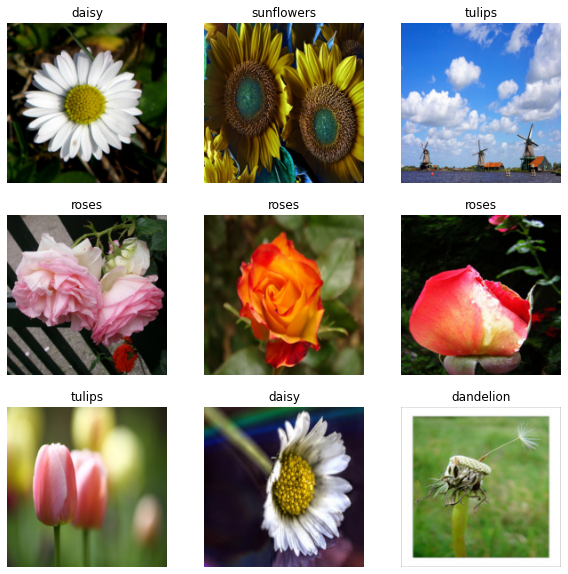

In [28]:
import matplotlib.pyplot as plt
inv_map = {v: k for k, v in class_names.items()}
plt.figure(figsize=(10, 10))
for image, label in train_generator:
  print(image.shape)
  print(label.shape)
  print(label[0])
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i])
    plt.title(inv_map[np.argmax(label[i])])
    plt.axis("off")
  break

This is really something else. Images are really very diverse. And big, too! We scaled them all down to 180x180, but still, this is much much much more then 28x28. With 180x180 we have over 300.000 pixels for every image! This is way above what we can expect to handle with something like a SVM, especially because we have just 3000 images, about 500 per class! 
## Baseline model
Let's try a simple model, with just one `Conv2D`, one `MaxPool2d`, and one hidden `Dense` layer.

In [29]:
model = tf.keras.Sequential([
  Input(shape=IMAGE_SIZE + (3,)),
  Rescaling(1./255),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(train_generator.num_classes)
])

Note how we don't use an sigmoid activation in the output layer. We could do that, but this way, the relu can range from $[-Inf, Inf]$. If we do that, we need to specify that `from_logits=True`. If we add a sigmoid, we have to set `from_logits=False`.

In [30]:
model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 253472)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               32444544  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 32,446,085
Trainable params: 32,446,085
Non-trainable params: 0
____________________________________________

In [20]:
%%time
model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=10
)

Epoch 1/15
92/92 [==============================] - 15s 158ms/step - loss: 1.6101 - accuracy: 0.2254 - val_loss: 1.6009 - val_accuracy: 0.2449
Epoch 2/15
92/92 [==============================] - 14s 152ms/step - loss: 1.5978 - accuracy: 0.2492 - val_loss: 1.5872 - val_accuracy: 0.2777
Epoch 3/15
92/92 [==============================] - 14s 152ms/step - loss: 1.5855 - accuracy: 0.2535 - val_loss: 1.5340 - val_accuracy: 0.3051
Epoch 4/15
92/92 [==============================] - 14s 151ms/step - loss: 1.5265 - accuracy: 0.3039 - val_loss: 1.5103 - val_accuracy: 0.3037
Epoch 5/15
92/92 [==============================] - 14s 151ms/step - loss: 1.4910 - accuracy: 0.3284 - val_loss: 1.4766 - val_accuracy: 0.3338
Epoch 6/15
92/92 [==============================] - 14s 152ms/step - loss: 1.4881 - accuracy: 0.3200 - val_loss: 1.4690 - val_accuracy: 0.3434
Epoch 7/15
92/92 [==============================] - 14s 152ms/step - loss: 1.4729 - accuracy: 0.3370 - val_loss: 1.4717 - val_accuracy: 0.3475

## Hypertuning
Well, that is a disappointing result. Just 35%. Ok, it is better than the 20% you would expect from blind guesses, but still... Maybe we need some power from the kerastuner?

In [32]:
def build_model(hp):
    input = Input(shape = IMAGE_SIZE + (3,))
    
    x = Rescaling(1./255)(input)
    
    filters1 = hp.Int('filters1', 16, 64, 4)
    x = Conv2D(filters1, 3, activation='relu')(x)
    x = MaxPool2D((2,2))(x)
    
    filters2 = hp.Int('filters2', 16, 128, 8)
    for i in range(hp.Int('conv_layers', 0, 3)):
        x = Conv2D(filters2, 3, activation='relu')(x)
        x = MaxPool2D((2,2))(x)
        name = 'convlayer_{0}'.format(i)
        
    flat = Flatten()(x)

    units = hp.Int('units', 128, 512, 64)

    x = Dense(units, activation='relu')(flat)

    for i in range(hp.Int('dense_layers', 1, 5)):
        name = 'layer_{0}'.format(i)
        x = Dense(units=units, activation='relu')(x)

    drops = hp.Float('drops', 0.05, 0.4)
    x=Dropout(drops)(x)
    output = Dense(train_generator.num_classes)(x)

    model = Model(inputs = [input], outputs = [output])

    lr = hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')
    model.compile(loss=tf.losses.CategoricalCrossentropy(from_logits=True), 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics=['accuracy'])
    return model

In [ ]:
%%time
# this might crash your notebook if you're running it on the jupyterhub. On the colab, it will run.
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=5,
    seed=42,
    overwrite=True,
    directory='ktuner',
    project_name='flowers'
)
tuner.search(train_generator, validation_data = valid_generator, verbose=1)

Trial 4 Complete [00h 01m 33s]
val_loss: 1.6008775234222412

Best val_loss So Far: 1.6003628969192505
Total elapsed time: 00h 06m 07s

Search: Running Trial #5

Hyperparameter    |Value             |Best Value So Far 
filters1          |60                |48                
filters2          |56                |24                
conv_layers       |0                 |1                 
units             |256               |256               
dense_layers      |4                 |5                 
drops             |0.2078            |0.17315           
learning_rate     |0.00012932        |0.00044104        
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |1                 |1                 
tuner/round       |0                 |0                 

Epoch 1/2


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)
model = tuner.get_best_models()[0]
model.summary()

Ok, now let's try that out.

In [ ]:
history = model.fit(train_generator, epochs=10, 
                    validation_data=valid_generator, 
                    callbacks=[early_stop], verbose = 1)

# Rebuilding other architectures
That's is still disappointing! Maybe we can add some smart tricks by hand. If you have read the book, you have seen some smart architectures. We can build those by small units by hand, and add layers like that. Maybe these smart ideas can help us out. The InceptionUnit would look like this:

<img src=https://images.deepai.org/django-summernote/2019-06-18/2cec735b-2347-4ded-ae2b-e8a8384f7b46.png width=600/>

In [33]:
class InceptionUnit(tf.keras.layers.Layer):
    def __init__(self, conv1_filters, conv3_filters, conv5_filters, conv1_max_filters, pre_conv3_filters, 
                 pre_conv5_filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(filters=conv1_filters, kernel_size=1, strides=1, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(filters=conv3_filters, kernel_size=3, strides=1, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(filters=conv5_filters, kernel_size=5, strides=1, padding='same', activation='relu')
        self.conv1_max = tf.keras.layers.Conv2D(filters=conv1_max_filters, kernel_size=1, strides=1, padding='same', activation='relu')
        self.pre_conv3 = tf.keras.layers.Conv2D(filters=pre_conv3_filters, kernel_size=1, strides=1, padding='same', activation='relu')
        self.pre_conv5 = tf.keras.layers.Conv2D(filters=pre_conv5_filters, kernel_size=1, strides=1, padding='same', activation='relu')
        self.pre_conv1 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=1, padding='same')
    
    def call(self, inputs):
        c1 = self.conv1(inputs)
        pre_c3 = self.pre_conv3(inputs)
        c3 = self.conv3(pre_c3)
        pre_c5 = self.pre_conv5(inputs)
        c5 = self.conv5(pre_c5)
        pre_c1m = self.pre_conv1(inputs)
        c1m = self.conv1_max(pre_c1m)
        out = tf.concat([c1, c3, c5, c1m], axis=3)
        return out

Or, a ResNet module would could be build like this
<img src=https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/resnets_1.png 
     width=300/>

In [38]:
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            Conv2D(filters, kernel_size=3, strides=strides, padding='same'),
            BatchNormalization(),
            self.activation,
            Conv2D(filters, kernel_size=3, strides=1, padding='same'),
            BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                Conv2D(filters, kernel_size=1, strides=strides),
                BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [44]:
BATCH_SIZE = 32
img_height = 224
img_width = 224
IMAGE_SIZE = (img_height, img_width)
train_generator, valid_generator = generate_generators(data_dir, img_size=IMAGE_SIZE, batch=BATCH_SIZE, split=0.2, augment=False)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


Let's try to follow the architecture from ResNet, but make it smaller because we have just 5 classes.

In [45]:
from tensorflow.keras.layers import Activation
input = Input(shape = IMAGE_SIZE + (3,))
x = Rescaling(1./255)(input)
x = Conv2D(64, 7, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
prev = 64
for filters in [64]*3+[128]*4+[256]*6+[512]*3:
    strides=1 if filters == prev else 2
    x = ResidualUnit(filters, strides=strides)(x)

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(train_generator.num_classes)(x)

model = Model(inputs = [input], outputs=[output])

In [46]:
model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [48]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)       

In [ ]:
%%time
model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=5
)

Epoch 1/5
92/92 [==============================] - 214s 2s/step - loss: 1.7686 - accuracy: 0.2715 - val_loss: 1.6128 - val_accuracy: 0.2175
Epoch 2/5
62/92 [===================>..........] - ETA: 1:06 - loss: 1.4068 - accuracy: 0.3750

This will take a really long time. Even on the GPU it is slow. On the jupyterhub we might have memory problems, too.

# pretrained model
But, hey, they already trained the models, right? So we could just download the pretrained architectures...

In [13]:
module_selection = ("inception_v3", 299) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32

Using https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4 with input size (299, 299)


In [14]:
train_generator, valid_generator = generate_generators(data_dir, img_size=IMAGE_SIZE, batch=BATCH_SIZE, split=0.2, augment=False)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [15]:
%%time
# this takes about 2 minutes to build
import tensorflow_hub as hub
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))

CPU times: user 3.9 s, sys: 836 ms, total: 4.73 s
Wall time: 6.02 s


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [17]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [18]:
%%time
# trains 3 epochs in about 5min on the jupyterhub, 3min30s on colab with gpu
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=3, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/3
91/91 [==============================] - 99s 1s/step - loss: 0.9725 - accuracy: 0.7045 - val_loss: 0.7195 - val_accuracy: 0.8651
Epoch 2/3
91/91 [==============================] - 98s 1s/step - loss: 0.7394 - accuracy: 0.8428 - val_loss: 0.7182 - val_accuracy: 0.8622
Epoch 3/3
91/91 [==============================] - 97s 1s/step - loss: 0.7032 - accuracy: 0.8555 - val_loss: 0.6769 - val_accuracy: 0.8835
CPU times: user 47min 15s, sys: 3min 13s, total: 50min 28s
Wall time: 5min 5s


This shows:
- the big architectures need a lot of data and time to train
- using pretrained models for transfer learning works pretty well (if you are lucky!) This will save us a lot of time and effort, if they are available for our task at hand.
- We get pretty good accuracy in this case! 

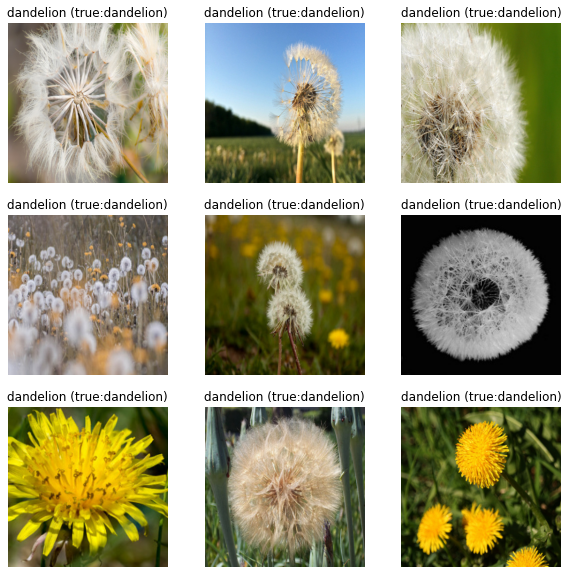

In [25]:
import matplotlib.pyplot as plt
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

images, label = next(valid_generator)
prediction_scores = model.predict(images)

predicted_index = np.argmax(prediction_scores, axis=1)
true_index = np.argmax(label, axis=1)
mismatches = true_index != predicted_index


misclass_img = image[mismatches]
mislab = [get_class_string_from_index(l) for l in predicted_index[mismatches]]
truelab = [get_class_string_from_index(l) for l in true_index[mismatches]]

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(get_class_string_from_index(predicted_index[i]) + " (true:" + 
              get_class_string_from_index(true_index[i])+ ")")
    plt.axis("off")

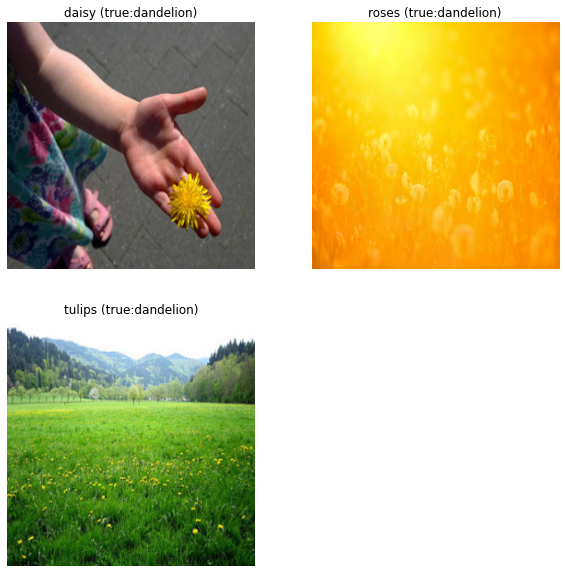

In [26]:
image, label = next(valid_generator)
prediction_scores = model.predict(image)

predicted_index = np.argmax(prediction_scores, axis=1)
true_index = np.argmax(label, axis=1)
mismatches = true_index != predicted_index

misclass_img = image[mismatches]
mislab = [get_class_string_from_index(l) for l in predicted_index[mismatches]]
truelab = [get_class_string_from_index(l) for l in true_index[mismatches]]

plt.figure(figsize=(10, 10))
n = int(np.ceil(np.sqrt(len(misclass_img))))

for i, image in enumerate(misclass_img):
    ax = plt.subplot(n, n, i + 1)
    plt.imshow(image)
    plt.title(mislab[i] + " (true:" + truelab[i] + ")")
    plt.axis("off")